# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions

In [82]:
#REMOVE SOME HARD CODING. FOR EXAMPLE: "Ne-Ne" and "Ne" which is used further down.


import numpy as np
from ase.io import read,write
from ase.build import bulk
from ase import Atoms
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
import seaborn as sns

atom = 'Fe'
sigma = 2.26738 
epsilon = 0.70641 
N = 2

LJ = bulk(atom, 'bcc', a=2.866)
LJ = LJ * [N, N, N]
calc = LennardJones(sigma=sigma, epsilon=epsilon)
LJ.calc = calc 

Fit_on_forces = True  #Enable/disable option for fitting CCS potential to atomic forces. 
LJ


Atoms(symbols='Fe8', pbc=True, cell=[[-2.866, 2.866, 2.866], [2.866, -2.866, 2.866], [2.866, 2.866, -2.866]], calculator=LennardJones(...))

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [58]:
# CHECK THE RATTLE FUNCTION TO MAKE SURE THAT WE DO NOT GET THE SAME RATTLES EVERYTIME

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude = 0.03  # 0.02 and disp_steps 5 leads to decieving results!
disp_steps = 5
rounds = 2

trainset_list="file_list" # List of strucutres to include in the data-base (see below)
f = open(trainset_list, "w")
counter = 1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 11):
        new_cell = orig_cell * scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < 10:
                xyz_file = f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file, rattle_struc)
                print(xyz_file, file=f)
                counter += 1

f.close()
       

### BUILD REFERENCE DATA-BASE

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S1.xyz
    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    CALCULATED_DATA/S5.xyz
    CALCULATED_DATA/S6.xyz
    CALCULATED_DATA/S7.xyz
    CALCULATED_DATA/S8.xyz
    CALCULATED_DATA/S9.xyz



In [59]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode='CCS', DFT_DB='LJ.db', file_list='file_list', overwrite=True)

    Building data-bases: 100%|██████████| 110/110 [00:31<00:00,  3.52it/s]


In [84]:
from ase.db import connect
from ase.io.vasp import read_vasp_out

db = connect('utbilar.db')
path = '/home/armin/Documents/Armin_phonon_DOS/0p/QHA_2x2x2/1.000/PP/OUTCAR0p/'
for i in range(1, 23):
    atoms = read_vasp_out(path +'OUTCAR'+ str(i))
    db.write(atoms)

In [61]:
from ase.io.vasp import read_vasp
db = connect('mposcar.db')
path = '/home/armin/Downloads/Exjobb/Basic_Tutorial/MPOSCAR/'
for i in range(58, 73):
    for j in range(-5, 6, 2):
        atoms = read_vasp(path + 'MPOSCAR' + str(i) + str(j))
        db.write(atoms, key=f'Mod {i}, Amp {j}')



In [76]:
path = '/home/armin/Downloads/Exjobb/Basic_Tutorial/MPOSCAR/'
distances = []
for i in range(58, 73):
    for j in range(-5, 6, 2):
        atoms1 = read(path + 'MPOSCARorig' + str(i) + str(j))
        atoms2 = read(path + 'MPOSCAR' + str(i) + str(j))
        
        if len(atoms1) == len(atoms2):
            cell_lengths = atoms1.cell.cellpar()[:3]
            max_distance = min(cell_lengths) / 2.0

            for k in range(len(atoms1)):
                atom1 = atoms1[k]
                atom2 = atoms2[k]
                atoms = Atoms([atom1, atom2])
                distance = atoms.get_distance(0, 1)
                if distance > max_distance:
                    atoms.wrap(pbc=True)
                    atoms.minimum_image()
                    distance = atoms.get_distance(0, 1)
                distances.append(distance)
        else:
            print(':(')
print(max(distances))

0.03597691209550125


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [86]:
import shutil

shutil.copy('/home/armin/Downloads/mposcar_PBE_U4.db', '/home/armin/Downloads/Exjobb/Basic_Tutorial/')
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS", DFT_DB="mposcar_PBE_U4.db", include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 90/90 [00:08<00:00, 11.16it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [78]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Fe-Fe": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.87,
                        "range_width": 0.2 
                },
                "Fe-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.94,
                        "range_width": 0.2
                },
                "Fe-P": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 5.05,
                        "range_width": 0.2
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.59,
                        "range_width": 0.2
                },
                "O-P": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.53,
                        "range_width": 0.2
                },
                "P-P": {
                        "Rcut": 6.0,
                        "Resolution": 0.008,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.86,
                        "range_width": 0.2
                }
        
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [79]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Fe', 'O', 'P']
    Applying monotonic constraints for pair:  Fe-Fe
    Applying monotonic constraints for pair:  Fe-O
    Applying monotonic constraints for pair:  Fe-P
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  O-P
    Applying monotonic constraints for pair:  P-P
    Merging intervals for pair Fe-Fe; number of intervals reduced from 257 to 18. 
    Merging intervals for pair Fe-O; number of intervals reduced from 507 to 74. 
    Merging intervals for pair Fe-P; number of intervals reduced from 358 to 22. 
    Merging intervals for pair O-O; number of intervals reduced from 453 to 137. 
    Merging intervals for pair O-P; number of intervals reduced from 548 to 79. 
    Merging intervals for pair P-P; number of intervals reduced from 286 to 18. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    There is linear depe

    Finding optimum switch: 100%|██████████| 27216/27216 [14:17<00:00, 31.74it/s]


    The best switch is (128, 5, 275, 275, 10, 156) with rmse: 0.296952858211535, corresponding to distances of [4.86 1.95 5.01 4.59 1.59 4.86] Å for element pairs ['Fe-Fe', 'Fe-O', 'Fe-P', 'O-O', 'O-P', 'P-P'].
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!


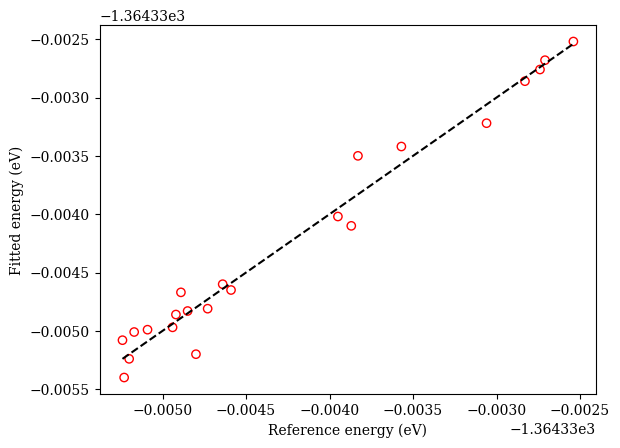

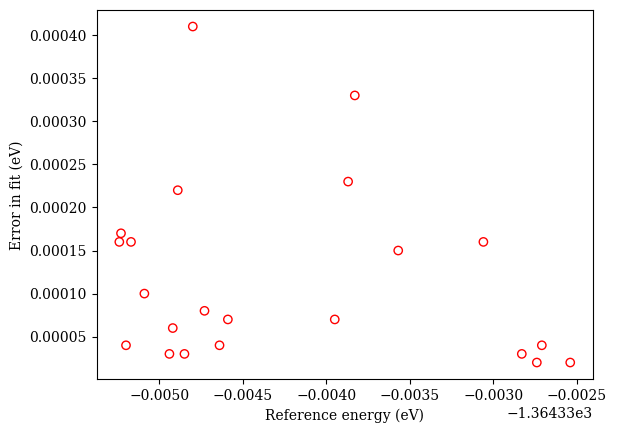

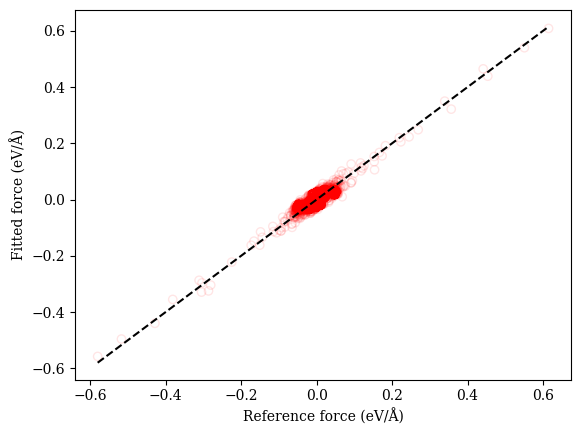

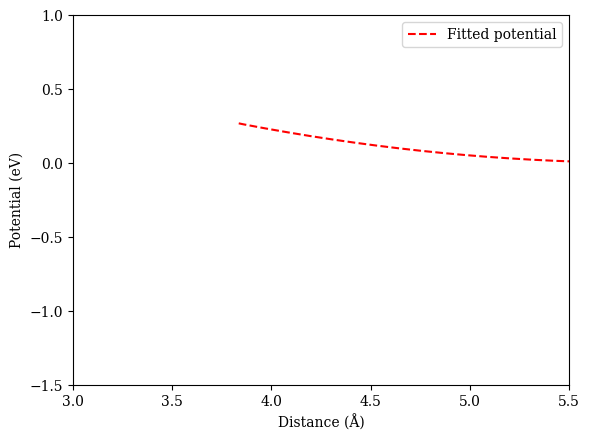

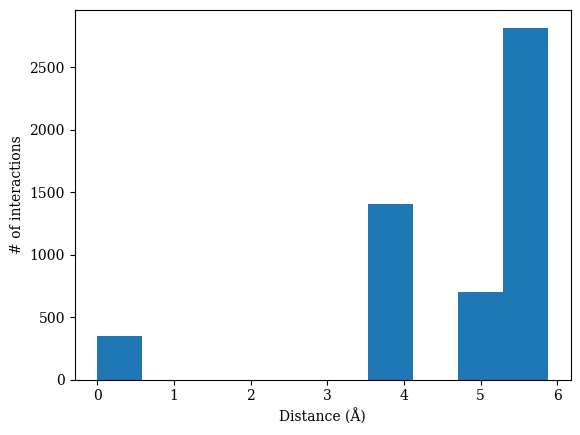

In [80]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r = np.array(CCS_params["Two_body"][f'{atom}-{atom}']["r"])
e = CCS_params["Two_body"][f'{atom}-{atom}']["spl_a"]
e_LJ = 4 * epsilon*((sigma/ r) ** 12 - (sigma/ r) ** 6)

try:
    err = np.loadtxt("CCS_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot([min(err[:, 0]),max(err[:, 0])],[min(err[:, 0]),max(err[:, 0])], '--', color='black'  )
    plt.scatter(err[:, 0],err[:, 1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:, 0],err[:, 2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F = np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:, 0]), max(err_F[:, 0])], [min(err_F[:, 0]), max(err_F[:, 0])], '--', color='black')
    plt.scatter(err_F[:, 0],err_F[:, 1], facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass


plt.xlim(3, 5.5)
plt.ylim(-1.5, 1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
#plt.plot(r, e_LJ, color='black', label="Ref. Lennard-Jones potential")
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

d = []
for t in training_set["energies"]:
    d.extend(training_set["energies"][t][f'{atom}-{atom}'])
plt.xlabel('Distance (Å)')
plt.ylabel('# of interactions')
plt.hist(d) 
plt.show()


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [ ]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS", CCS_params="CCS_params.json", DFT_DB="FP_PBE_U4.db")

100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


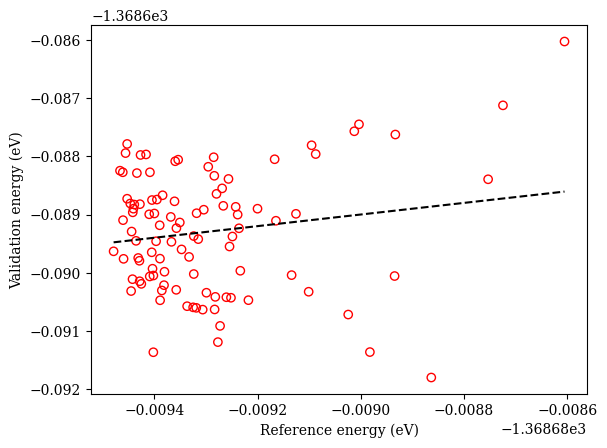

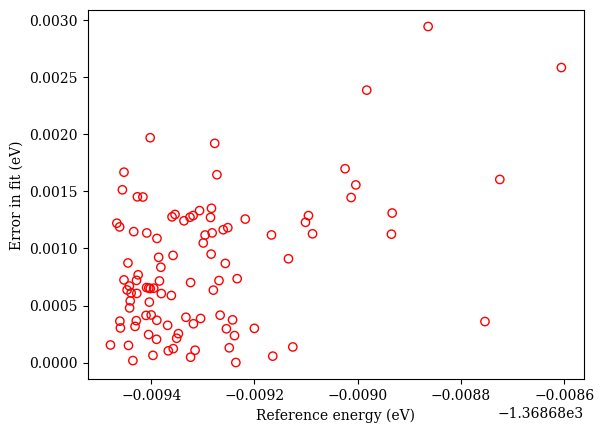

In [ ]:
try:
    err = np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot([min(err[:, 0]), max(err[:, 0])], [min(err[:, 0]),max(err[:, 0])], '--', color='black')
    plt.scatter(err[:, 0], err[:, 1], facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:, 0], err[:, 2], facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Geometry optimization

In [83]:
from ase.optimize import BFGS 
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from IPython.utils import io 


struct = db.connect('utbilar.db')
calc = CCS(CCS_params=CCS_params)

for row in tqdm(struct.select(), total=len(struct)):
    structure = row.toatoms()
    structure.calc = calc
    structure.get_forces()
    struct.write(structure, CCS=True)
    
with io.capture_output() as captured:
    opt = BFGS(structure, trajectory='opt.traj')
    run = opt.run(fmax=0.001)

  0%|          | 0/22 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/db/core.py:105: UserWarning: It is best not to use keys (CCS) that are also a chemical formula.  If you do a "db.select('CCS')",you will not find rows with your key.  Instead, you wil get rows containing the atoms in the formula!
  warnings.warn(
100%|██████████| 22/22 [00:19<00:00,  1.12it/s]


KeyboardInterrupt: 

### Equation of state

700.1818282228774 GPa


<AxesSubplot: title={'center': 'sj: E: -5.375 eV, V: 11.121 Å$^3$, B: 700.182 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

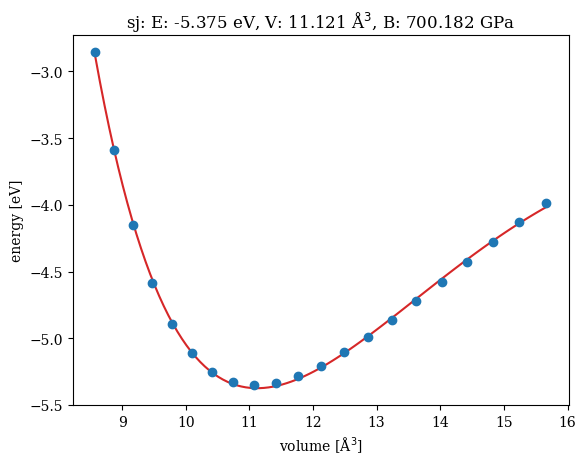

In [ ]:
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.units import kJ
from ase.eos import EquationOfState

# Need GeoOpt for bigger molecules.

a = 2.866  # Lattice constant for BCC Fe
b = a / 2
Fe = Atoms('Fe',
           cell=[(-b, b, b), (b, -b, b), (b, b, -b)], 
           pbc=1,
           calculator=LennardJones(sigma=2.27, epsilon=0.706))
cell = Fe.get_cell()
traj = Trajectory('Fe.traj', 'w')
for x in np.linspace(0.9, 1.1, 21):
    Fe.set_cell(cell * x, scale_atoms=True)
    cur_nrg = Fe.get_potential_energy()
    traj.write(Fe)

configs = read('Fe.traj@:')

volumes = [Fe.get_volume() for Fe in configs]
energies = [Fe.get_potential_energy() for Fe in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ *1.0e24, 'GPa')
eos.plot('FeEos.png')  


### Phonon spectra

Number of Cells 22


/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


[Phonopy] Phonon DOS:


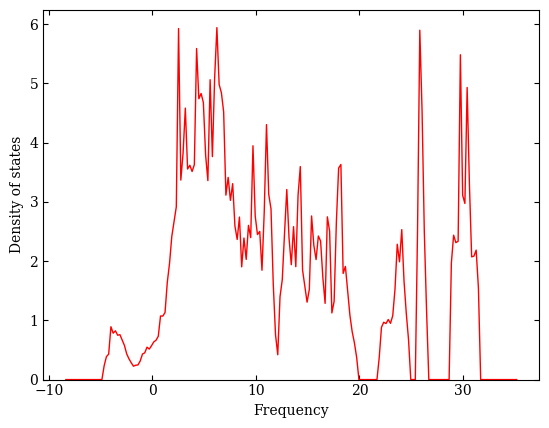

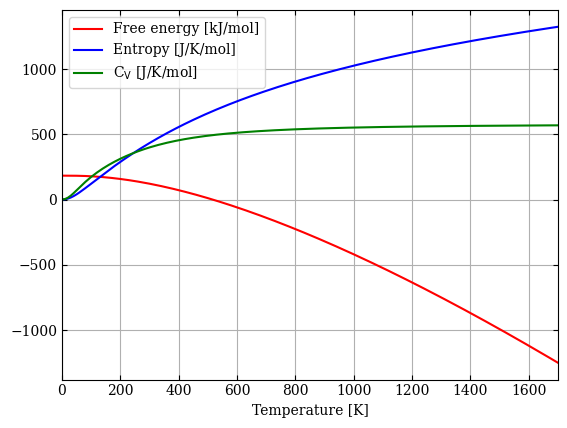

In [85]:
import phononmin as pm

with open("CCS_params.json", "r") as f:
        CCS_params = json.load(f)
calc = pm.setup_model(CCS_params)

unitcell = read('utbilar.db', do_not_split_by_at_sign=True) #vasp-format can only store 1 Atoms object
#write('POSCAR', unitcell)
cell, _ = pm.read_crystal_structure('POSCAR0p_Jolla', interface_mode='vasp')
N = 2
smat = [[N, 0, 0], [0, N, 0], [0, 0, N]]
phonon = pm.Phonopy(cell, smat)
phonon.generate_displacements(distance=0.02)
set_of_forces = pm.run_gap(calc, phonon)
phonon.produce_force_constants(forces=set_of_forces)
mesh = (8, 8, 8)
pm.run_dos(phonon, mesh)
pm.run_thermal(phonon, mesh)
phonon.save(settings={'force_constants': True})


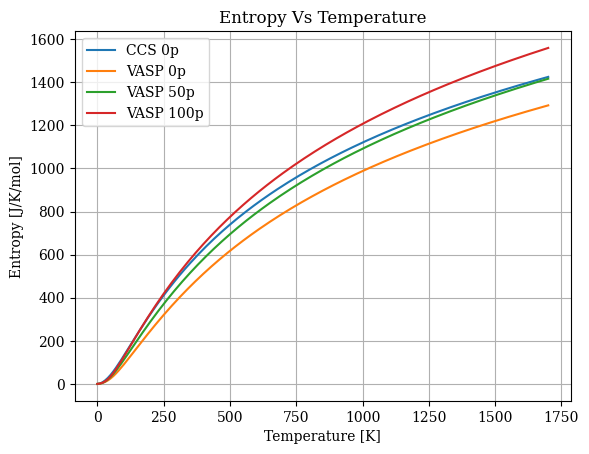

In [ ]:
import matplotlib.pyplot as plt



entropy_ccs = np.genfromtxt('entropy_ccs.dat')[1:, 1:]
entropy_jolla0 = np.genfromtxt('entropy_0pVASP.dat')[1:, 1:]
entropy_jolla50 = np.genfromtxt('entropy_50pVASP.dat')[1:, 1:]
entropy_jolla100 = np.genfromtxt('entropy_100pVASP.dat')[1:, 1:]
temperature = [i for i in range(0, 1701, 10)]
ax = plt.subplots()
ax.plot(temperature, entropy_ccs, label='CCS 0p')
ax.plot(temperature, entropy_jolla0, label='VASP 0p')
ax.plot(temperature, entropy_jolla50, label='VASP 50p')
ax.plot(temperature, entropy_jolla100, label='VASP 100p')
ax.legend()
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Entropy [J/K/mol]')
ax.set_title('Entropy Vs Temperature')
ax.grid()
plt.show()



In [ ]:
import pandas as pd
import plotly.express as px
b = []
a = [b.append(np.genfromtxt('entropy_ccs.dat')[1, 1:i]) for i in range(0,171)]

print(b)
#pd.DataFrame(np.column_stack([entropy_ccs, entropy_jolla0, entropy_jolla50, entropy_jolla100]), columns='[ccs, jolla0, jolla50, jolla100]')

[array([], dtype=float64), array([], dtype=float64), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])

/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ccs_fit/scripts/ccs_export_FF.py:25: RuntimeWarning: overflow encountered in square
  return De*((1-np.exp(-a*(r-re)))**2-1)


Buckingham fit (not optimised) for element pair Fe-Fe;     V(r) = 33.77*exp(-9.67*r) -(-4468.79)/r^6.
Lennard Jones fit (not optimised) for element pair Fe-Fe;  V(r) = 4*-137193.86*((0.45/r)^12 - (0.45/r)^6)
Morse fit (not optimised) for element pair Fe-Fe;          V(r) = -1.38*((1-np.exp(-1.99*(r-3.73)))^2 - 1)
Pedone fit (not optimised) for element pair Fe-Fe;         V(r) = -2132.21*((1-np.exp(-2.05*(r-0.32)))^2 - 1) + -18405555.71/r^12


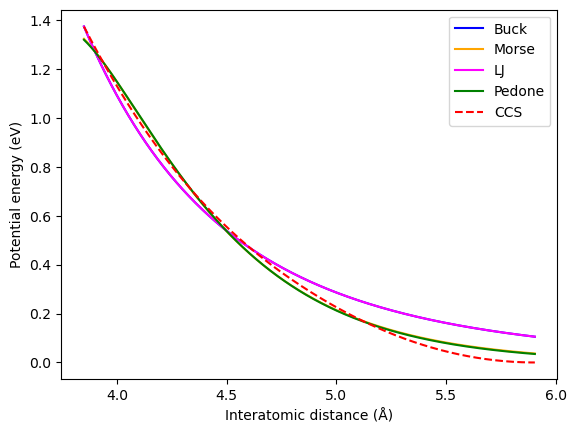

Buckingham fit (not optimised) for element pair Fe-O;     V(r) = -55.17*exp(-1.02*r) -(-126.64)/r^6.
Lennard Jones fit (not optimised) for element pair Fe-O;  V(r) = 4*6.07*((1.87/r)^12 - (1.87/r)^6)
Morse fit (not optimised) for element pair Fe-O;          V(r) = 5.41*((1-np.exp(-1.11*(r-1.77)))^2 - 1)
Pedone fit (not optimised) for element pair Fe-O;         V(r) = 4.36*((1-np.exp(-1.17*(r-2.08)))^2 - 1) + -3402.87/r^12


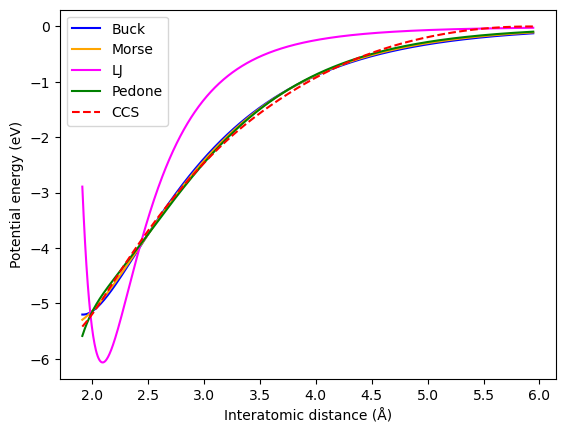

Buckingham fit (not optimised) for element pair Fe-P;     V(r) = 62.56*exp(-21.62*r) -(-2403.16)/r^6.
Lennard Jones fit (not optimised) for element pair Fe-P;  V(r) = 4*-3.51*((2.53/r)^12 - (2.53/r)^6)
Morse fit (not optimised) for element pair Fe-P;          V(r) = -3.94*((1-np.exp(-1.54*(r-2.61)))^2 - 1)
Pedone fit (not optimised) for element pair Fe-P;         V(r) = -1.19*((1-np.exp(-1.74*(r-3.48)))^2 - 1) + 2063982.15/r^12


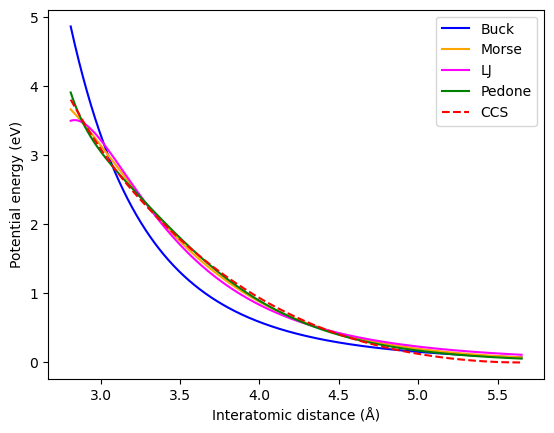

Buckingham fit (not optimised) for element pair O-O;     V(r) = 171.18*exp(-1.42*r) -(512.31)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*-2.86*((2.24/r)^12 - (2.24/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = -3.13*((1-np.exp(-1.45*(r-2.22)))^2 - 1)
Pedone fit (not optimised) for element pair O-O;         V(r) = -1.56*((1-np.exp(-1.64*(r-2.85)))^2 - 1) + 124811.28/r^12


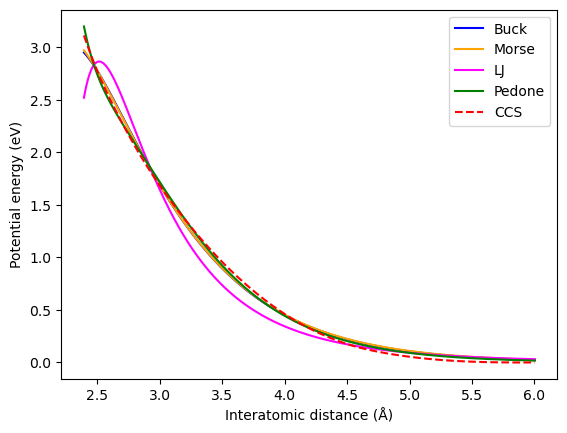

Buckingham fit (not optimised) for element pair O-P;     V(r) = -12.81*exp(-34.50*r) -(209.63)/r^6.
Lennard Jones fit (not optimised) for element pair O-P;  V(r) = 4*11.36*((1.50/r)^12 - (1.50/r)^6)
Morse fit (not optimised) for element pair O-P;          V(r) = 9.20*((1-np.exp(-1.08*(r-1.42)))^2 - 1)
Pedone fit (not optimised) for element pair O-P;         V(r) = 7.73*((1-np.exp(-1.15*(r-1.69)))^2 - 1) + -377.78/r^12


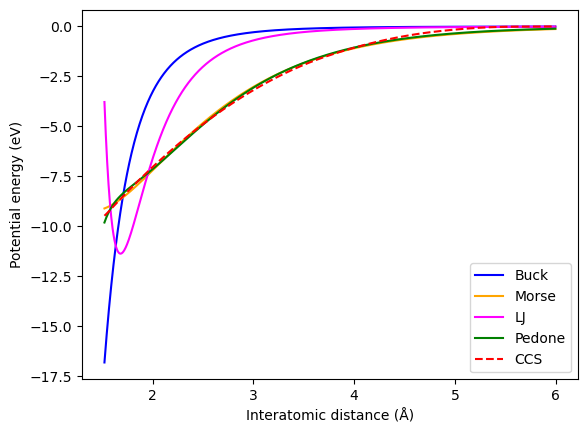

/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ccs_fit/scripts/ccs_export_FF.py:25: RuntimeWarning: overflow encountered in exp
  return De*((1-np.exp(-a*(r-re)))**2-1)


Buckingham fit (not optimised) for element pair P-P;     V(r) = 383.76*exp(-56.31*r) -(-13321.46)/r^6.
Lennard Jones fit (not optimised) for element pair P-P;  V(r) = 4*-11.33*((2.62/r)^12 - (2.62/r)^6)
Morse fit (not optimised) for element pair P-P;          V(r) = -5.13*((1-np.exp(-1.77*(r-3.54)))^2 - 1)
Pedone fit (not optimised) for element pair P-P;         V(r) = -5.13*((1-np.exp(-1.77*(r-3.54)))^2 - 1) + 1.00/r^12


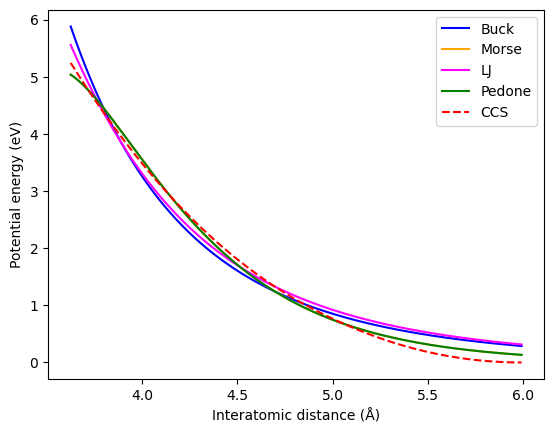

In [ ]:
from ccs_fit.scripts.ccs_export_FF import write_FF

write_FF("CCS_params.json")

### Cleaning up

In [74]:
import os, glob
import itertools as it

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass

L1 = glob.glob("CALCULATED_DATA/*")
L2 = glob.glob("CCS_*")
L3 = glob.glob("*.traj")
L4 = glob.glob("*.png")
L5 = glob.glob("*.db")

for file in it.chain(L1, L2, L3, L4, L5,):
    rm(file)
files = [
    "structures.json",
    "file_list",
    "ccs.spl",
    'POSCAR',
    'TDOS',
    'thermal_properties.yaml',
    'CCS.lammps',   
    'Pendone.dat',
    'Buckingham.dat',
    'Morse.dat', 
]
for file in files:
    rm(file)
